# **Extracting Topic model by  "Latent Dirichlet Allocation (LDA)"  of kepler's book: "Astronomia Nova** "
<font size="4">
This notebook demonstrates how to **extract topics **  from documents, corpus, book. We visualize the result in an informative way. Here, an unsupervised learning model LDA is used. **Topic modelling** is based on the basic assumptions that each corpus (book)  consists of different topics and each topic consists of a collection of words.
<font/>


### Import the required tools 

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import collections
import os
import logging
import warnings
from itertools import permutations
from sklearn.metrics import make_scorer,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import sklearn_crfsuite  # to install this package in windows with pip please run: 'pip install sklearn-crfsuite'
from sklearn_crfsuite import metrics, scorers
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import eli5  # to install this package in windows with conda please run: 'conda install -c conda-forge eli5'
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from gensim import corpora, models  #  to install this package in windows with conda please run: 'models conda install -c conda-forge gensim'
nltk.download('wordnet')
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\moha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Please download the data '01_df_v013.pickle' in github on  your local machine from  this directory: vorlesung2019/notebooks/yeghaneh/data

In [2]:
importVersion = '013'  # The  desired version pickle-file of your data (now we are working on version 013 of our data)

In [3]:
path = '../data/01_df_v{0}.pickle'.format(importVersion)  # Put the path of the data in your local machine here, consider the letter "r" before the path

### Let's use data "01_df_v013" to build a NER system. 
<font size="3">The data 01_df_v013 is annotated (labeled) data of english version of well-known kepler's book: New Astronomy (Latin: Astronomia nova). You can find that in the repository.
             </font>


## **Read the data** 
<font size="3">The data  is saves as a pickle file. We read it as a pandas dataFrame. </font>

In [4]:
dfAstroNova = pd.read_pickle(path)  # Put the path of the data in your local machine here, consider the letter "r" before the path

<font size="4"> Sort the data based on the chapters of the book 
</font>

In [5]:
dfAstroNova['chapter'] = dfAstroNova.chapter.replace("appendix b",np.nan).astype(float)  
dfAstroNova.sort_values(by='chapter' , inplace=True)
dfAstroNova.chapter.fillna('appendix b', inplace=True)

In [6]:
len(dfAstroNova)   # Number of rows.

1605

In [7]:
dfAstroNova.head(5)  

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
18,"<p><span class=""anchor"" id=""bookmark0""></span>...",Chapter 1,[],[],1,[],[],[],[Chapter 1],"[[(Chapter, None), (1, NUM)]]"
34,"<p>But before that, I shall prove in this firs...","But before that, I shall prove in this first p...",[],[],1,[],[],[],"[But before that, I shall prove in this first ...","[[(But, None), (before, None), (that, None), (..."
33,<p>But since the sun's mean and apparent motio...,But since the sun's mean and apparent motions*...,[],"[Mysterium cosmographicum,]",1,[],[],[ Terms: * The sun's apparent position is that...,[But since the sun's mean and apparent motions...,"[[(But, None), (since, None), (the, None), (su..."
32,<p>Now the causes and measures of these inequa...,Now the causes and measures of these inequalit...,[],[],1,[],[],[ 5],[Now the causes and measures of these inequali...,"[[(Now, None), (the, None), (causes, None), (a..."
30,"<p>Again, however, it was noticed that these l...","Again, however, it was noticed that these loop...",[],[],1,[],[],[],"[Again, however, it was noticed that these loo...","[[(Again, None), (however, None), (it, None), ..."


In [8]:
dfAstroNova[740:745]

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
594,"<p><span class=""anchor"" id=""bookmark1""></span>...","Whether the motion from the sun, like its ligh...",[{'#fn1': 'άντίφραχις.↩'}],[],35,[],[],[],"[Whether the motion from the sun, like its lig...","[[(Whether, None), (the, None), (motion, None)..."
596,"<p>And concerning the first, it is worthy of c...","And concerning the first, it is worthy of cons...",[],[],35,[],[],[],"[And concerning the first, it is worthy of con...","[[(And, None), (concerning, None), (the, None)..."
595,<p>This is a good time for me to take up the o...,This is a good time for me to take up the obje...,[],[species],35,[],[],[],[This is a good time for me to take up the obj...,"[[(This, None), (is, None), (a, None), (good, ..."
598,"<p>But it is answered, first, that the analogy...","But it is answered, first, that the analogy be...",[],[],35,[],[],[],"[But it is answered, first, that the analogy b...","[[(But, None), (it, None), (is, None), (answer..."
599,<p>On this account I would nearly separate lig...,On this account I would nearly separate light ...,[],[],35,[],[],[],[On this account I would nearly separate light...,"[[(On, None), (this, None), (account, None), (..."


In [9]:
dfAstroNova[1585:1590]

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
1568,<p>{marginal: The words of the observation hav...,Consider whether the meaning could be this: t...,[],[],70,[],[],[ The words of the observation have their comm...,[Consider whether the meaning could be this: t...,"[[(Consider, None), (whether, None), (the, Non..."
1569,<p>This interpretation is furthered by the obs...,This interpretation is furthered by the observ...,[],[],70,[],[],[],[This interpretation is furthered by the obser...,"[[(This, None), (interpretation, None), (is, N..."
0,<p>Appendix B</p>,Appendix B,[],[],appendix b,[],[],[],[Appendix B],"[[(Appendix, None), (B, None)]]"
1,"<p><span class=""anchor"" id=""bookmark0""></span>...",On the Table of Oppositions in Chapter 15,[],[],appendix b,[],[],[],[On the Table of Oppositions in Chapter 15],"[[(On, None), (the, None), (Table, None), (of,..."
2,"<p>by Yaakov Zik <span style=""font-variant: sm...",by Yaakov Zik Table i:,[],[],appendix b,[],[],[],[by Yaakov Zik Table i:],"[[(by, None), (Yaakov, None), (Zik, None), (Ta..."


In [10]:
dfAstroNova.tail(5)

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
13,<p>{table: appendix B t 2}</p>,,[],[],appendix b,[],[ appendix B t 2],[],[],[]
14,"<p>Kepler's table, for comparison {table: appe...","Kepler's table, for comparison",[],[],appendix b,[],[ appendix B t 3],[],"[Kepler's table, for comparison]","[[(Kepler, None), (s, None), (table, None), (f..."
15,<p>Mars from Earth to be a little greater than...,Mars from Earth to be a little greater than ha...,[{'#fn6': ' Kepler's observations yield topoce...,[],appendix b,[],[],[],[Mars from Earth to be a little greater than h...,"[[(Mars, None), (from, None), (Earth, None), (..."
16,"<p><img height=""300"" src=""media/image1.jpeg"" w...","As shown in Figure 2B, the Sun is assumed to ...",[],[],appendix b,[ appendix b gr 1],[],[],"[As shown in Figure 2B, the Sun is assumed to ...","[[(As, None), (shown, None), (in, None), (Figu..."
17,<p>The Sun moved westward and its longitude de...,The Sun moved westward and its longitude decre...,[],[4<sup>h</sup> 23<sup>m </sup>],appendix b,[],[],[],[The Sun moved westward and its longitude decr...,"[[(The, None), (Sun, None), (moved, None), (we..."


## **Primary Data Exploration**

In [11]:

dfAstroNova["text"][5]    # 5th row of the data in the format of text 

"The time is measured from midnight; Gregorian dates are obtained by adding 10 days to Kepler's dates. The dates are given in old style."

In [12]:
dfAstroNova["tagged"][5] # 5th row of the data in a format (token, label). A list of lists of tuples! later position tags of the token will be added to each tuple. the tokens are chosen before by some rules.

[[('The', 'None'),
  ('time', 'None'),
  ('is', 'None'),
  ('measured', 'None'),
  ('from', 'None'),
  ('midnight', 'None'),
  ('Gregorian', 'None'),
  ('dates', 'None'),
  ('are', 'None'),
  ('obtained', 'None'),
  ('by', 'None'),
  ('adding', 'None'),
  ('10', 'NUM'),
  ('days', 'None'),
  ('to', 'None'),
  ('Kepler', 'None'),
  ('s', 'None'),
  ('dates', 'None')],
 [('The', 'None'),
  ('dates', 'None'),
  ('are', 'None'),
  ('given', 'None'),
  ('in', 'None'),
  ('old', 'None'),
  ('style', 'None')]]

In [12]:
dfAstroNova= dfAstroNova.loc[dfAstroNova.chapter==15]

In [13]:
 df = sum(dfAstroNova['tagged'], [])  # Flatt the data by removing first lists
len(df)

251

In [14]:
df[5]  

[('Subtracting', 'None'),
 ('this', 'None'),
 ('from', 'None'),
 ('11', 'NUM'),
 ('hours', 'None'),
 ('30', 'NUM'),
 ('minutes', 'None'),
 ('gives', 'None'),
 ('December 28 ', 'DATE'),
 ('at', 'None'),
 ('3h 58m', 'TIME'),
 ('after', 'None'),
 ('noon', 'None'),
 ('as', 'None'),
 ('the', 'None'),
 ('moment', 'None'),
 ('of', 'None'),
 ('true', 'None'),
 ('opposition', 'None')]

In [15]:
df_flatten = sum(df,[])  # Flatt the data by removing the second list


In [16]:
df_flatten[0:20]  # Here we have tokens (entities) with their labels

[('On', 'None'),
 ('the', 'None'),
 ('night', 'None'),
 ('following', 'None'),
 ('1582 December 28', 'DATE'),
 ('at', 'None'),
 ('11h 30m', 'TIME'),
 ('Mars', 'None'),
 ('was', 'None'),
 ('observed', 'None'),
 ('at', 'None'),
 ("16° 47' Cancer", 'COORD'),
 ('6', 'NUM'),
 ('while', 'None'),
 ('the', 'None'),
 ('true', 'None'),
 ('position', 'None'),
 ('of', 'None'),
 ('the', 'None'),
 ('sun', 'None')]

In [17]:
len(df_flatten)  # Number of all tokens (roughly speaking all words or entities)

4364

In [18]:

tokens = [x[0] for x in df_flatten]  # Extract the tokens for further use in the frequency plot

In [19]:
labels=([x[1] for x in df_flatten])  # Extract the labels for further use in the frequency plot

In [20]:
tokens[0:5]

['On', 'the', 'night', 'following', '1582 December 28']

In [21]:
labels[0:5]

['None', 'None', 'None', 'None', 'DATE']

## **Visualization**

### Frequency plot of all words in all chapter of book

<font size="3">
Frequency plot of all tokens in text, as you see there is a lot 'the', 'of',... in text, they normally consider as noise, we will back to that later.
<font/>

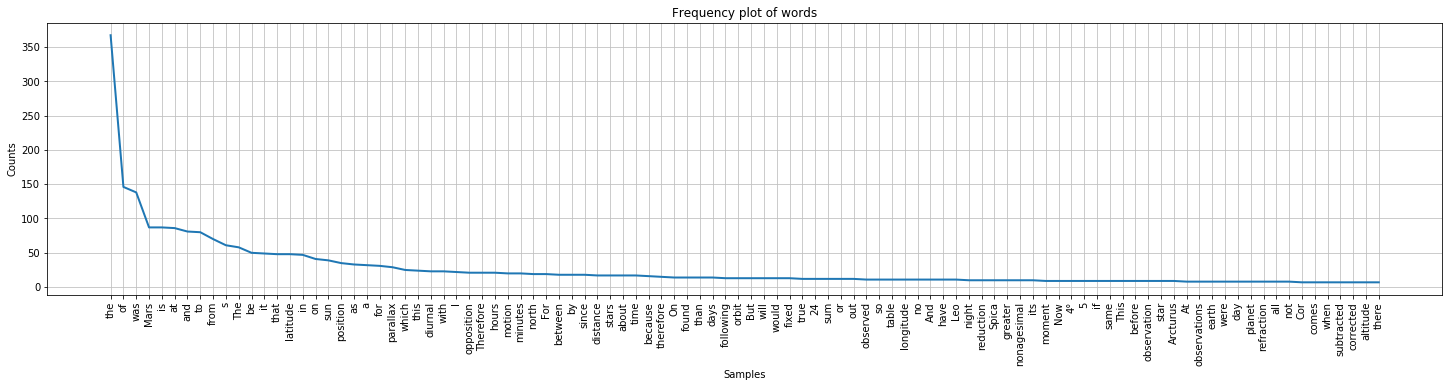

In [22]:
freqdist = nltk.FreqDist(tokens)
plt.figure(figsize=(25,5))
freqdist.plot(100, title='Frequency plot of words')


In [23]:
stop_words=["the", "of", "is", "to", "and","in", "be", "at", "that", "from", "it", "a", "as","this", "was" ] # we can consider these as stop words or we can use nltk stop words.

In [24]:
# nltk stop words
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
stop_words=stop_words.union(['I', 'And', 'For', 'A', 'The'])
#stop_words_nltk = set(stop_words)

# List of nltk stop words {‘ourselves’, ‘hers’, ‘between’, ‘yourself’, ‘but’, ‘again’, ‘there’, ‘about’, ‘once’, ‘during’, ‘out’, ‘very’, ‘having’, ‘with’, ‘they’, ‘own’, ‘an’, ‘be’, ‘some’, ‘for’, ‘do’, ‘its’, ‘yours’, ‘such’, ‘into’, ‘of’, ‘most’, ‘itself’, ‘other’, ‘off’, ‘is’, ‘s’, ‘am’, ‘or’, ‘who’, ‘as’, ‘from’, ‘him’, ‘each’, ‘the’, ‘themselves’, ‘until’, ‘below’, ‘are’, ‘we’, ‘these’, ‘your’, ‘his’, ‘through’, ‘don’, ‘nor’, ‘me’, ‘were’, ‘her’, ‘more’, ‘himself’, ‘this’, ‘down’, ‘should’, ‘our’, ‘their’, ‘while’, ‘above’, ‘both’, ‘up’, ‘to’, ‘ours’, ‘had’, ‘she’, ‘all’, ‘no’, ‘when’, ‘at’, ‘any’, ‘before’, ‘them’, ‘same’, ‘and’, ‘been’, ‘have’, ‘in’, ‘will’, ‘on’, ‘does’, ‘yourselves’, ‘then’, ‘that’, ‘because’, ‘what’, ‘over’, ‘why’, ‘so’, ‘can’, ‘did’, ‘not’, ‘now’, ‘under’, ‘he’, ‘you’, ‘herself’, ‘has’, ‘just’, ‘where’, ‘too’, ‘only’, ‘myself’, ‘which’, ‘those’, ‘i’, ‘after’, ‘few’, ‘whom’, ‘t’, ‘being’, ‘if’, ‘theirs’, ‘my’, ‘against’, ‘a’, ‘by’, ‘doing’, ‘it’, ‘how’, ‘further’, ‘was’, ‘here’, ‘than’} 


<font size="3">
We can consider these words like 'the', 'of',... as noises. so we temporary remove those! 
<font/>

In [25]:
new_tokens = []     
for w in tokens:
    if w not in stop_words: new_tokens.append(w)      

### Frequency plot of all words in all chapter of book after removing the stop words

<font size="3">
It shows word "sun" is most common word.  We can also see the word Mars, planet, eccentric as common words in the book 
<font/>

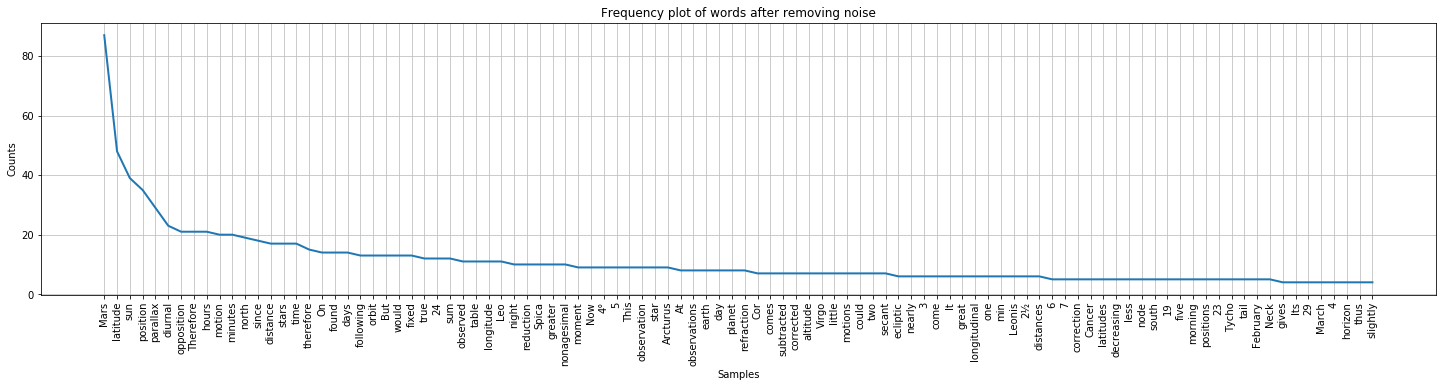

In [26]:
freqdist = nltk.FreqDist(new_tokens) 
plt.figure(figsize=(25,5)) 
freqdist.plot(100, title='Frequency plot of words after removing noise')

<font size="4">
Do we need more insight than frequency plot of word for see content of the book? the question is answered by the follwoing cells through investigation of "topic modelling"
<font/>

## **Topic Modelling by LDA**

 Here you see an structured workflow to build an insightful "topic model" based on the Latent Dirichlet Allocation (LDA) algorithm,  modeled as Dirichlet distributions Dir(α).
 For more detail you can read: <p>
http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf
    </p>

### **Pre-processing**

<font size="3">
Since we alreay tokenized the text (split text into  word without punctuation) and removed stopwrods, we only need to **lemmatize** and **stemm** the tokens.
<font/>

In [27]:
mytext = nltk.Text(new_tokens) 

#### Lemmatization 

<font size="3">
Lemmatization, takes into consideration the morphological analysis of the words. For instance  "do", "does", "did" and "doing" are forms of the same lexeme with "do" as the lemma. Another example would be  "car", "cars", "automobile"
<font/>

In [28]:
#lemmatization
w_lemmatize= WordNetLemmatizer()
my_text_lemmatize = [w_lemmatize.lemmatize(word) for word in mytext]


#### Stemming

<font size="3">
Stemming algorithms work by cutting off the end or the beginning of the word, by taking into account a list of common prefixes and suffixes. It reduces words to their word stem or root form. For instance, stemming for root word "like" include:"likes", "liked", "likely", "liking
<font size=/>

# stemming 
p_stemmers=PorterStemmer()  
my_text_lemm_stemmer = [p_stemmers.stem(word) for word in my_text_lemmatize]

In [30]:
my_text_lemmatize=[my_text_lemmatize] #make a list of list

#### Select a document to preview after preprocessing.

In [31]:
Dic=corpora.Dictionary(my_text_lemmatize)

### **Bag of Words on the Data set**

<font size="4">
Our dictionary must be converted to "bag of word". Frequency of occurrence of each word is used as a feature for training a classifier. It means it should contain the number of times a word appears
<font size>

In [33]:
corpus = [Dic.doc2bow(text) for text in my_text_lemmatize]

#### Running LDA using Bag of Words**

In [41]:
ldamodel =models.ldamodel.LdaModel(corpus, num_topics=3,  id2word = Dic, passes=2, iterations=15)

In [42]:
lda_topics=ldamodel.print_topics()

In [43]:
lda_topics

[(0,
  '0.023*"Mars" + 0.015*"latitude" + 0.013*"sun" + 0.010*"position" + 0.008*"parallax" + 0.008*"motion" + 0.008*"distance" + 0.007*"star" + 0.007*"hour" + 0.006*"opposition"'),
 (1,
  '0.023*"Mars" + 0.011*"latitude" + 0.010*"position" + 0.008*"sun" + 0.007*"star" + 0.006*"distance" + 0.006*"parallax" + 0.006*"diurnal" + 0.006*"Therefore" + 0.006*"motion"'),
 (2,
  '0.030*"Mars" + 0.019*"latitude" + 0.014*"position" + 0.013*"sun" + 0.011*"parallax" + 0.010*"motion" + 0.009*"star" + 0.009*"diurnal" + 0.008*"day" + 0.008*"opposition"')]

In [44]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, Dic)


C:\Users\moha\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Topic Modelling of chapter 5 

In [38]:
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
2     -0.008621 -0.0       1        1  99.948883
0      0.000478 -0.0       2        1   0.026144
1      0.008143 -0.0       3        1   0.024973, topic_info=     Category       Freq       Term      Total  loglift  logprob
term                                                            
368   Default  35.000000      power  35.000000  30.0000  30.0000
81    Default  30.000000       bodi  30.000000  29.0000  29.0000
468   Default  28.000000        sun  28.000000  28.0000  28.0000
358   Default  21.000000     planet  21.000000  27.0000  27.0000
278   Default  23.000000      light  23.000000  26.0000  26.0000
92    Default  17.000000     center  17.000000  25.0000  25.0000
308   Default  19.000000       move  19.000000  24.0000  24.0000
305   Default  17.000000     motion  17.000000  23.0000  23.0000
537   Default  14.000000      world  14.000000  22.0000  22.0000
91    Default  13.000000       caus  13.000000  21.0000  21.0000
156   Default  14.000000      earth  14.000000  20.0000  20.0000
495   Default  11.000000       time  11.000000  19.0000  19.0000
152   Default  12.000000    distanc  12.000000  18.0000  18.0000
439   Default  12.000000       sinc  12.000000  17.0000  17.0000
485   Default  10.000000   therefor  10.000000  16.0000  16.0000
334   Default  10.000000        one  10.000000  15.0000  15.0000
447   Default  10.000000      sourc  10.000000  14.0000  14.0000
488   Default  10.000000      thing  10.000000  13.0000  13.0000
306   Default  10.000000      motiv  10.000000  12.0000  12.0000
360   Default   9.000000      point   9.000000  11.0000  11.0000
87    Default   8.000000        but   8.000000  10.0000  10.0000
201   Default   8.000000     follow   8.000000   9.0000   9.0000
449   Default   7.000000      speci   7.000000   8.0000   8.0000
96    Default   8.000000      circl   8.000000   7.0000   7.0000
448   Default   7.000000      space   7.000000   6.0000   6.0000
236   Default   8.000000    illumin   8.000000   5.0000   5.0000
94    Default   6.000000    chapter   6.000000   4.0000   4.0000
296   Default   7.000000     matter   7.000000   3.0000   3.0000
345   Default   7.000000       part   7.000000   2.0000   2.0000
90    Default   7.000000      carri   7.000000   1.0000   1.0000
...       ...        ...        ...        ...      ...      ...
94     Topic3   0.001512    chapter   6.654166  -0.0947  -5.4788
92     Topic3   0.002779     center  17.916603  -0.4762  -4.8698
296    Topic3   0.001507     matter   7.023666  -0.1521  -5.4821
81     Topic3   0.003700       bodi  30.185667  -0.7117  -4.5836
91     Topic3   0.002178       caus  13.137468  -0.4096  -5.1135
468    Topic3   0.003408        sun  28.101391  -0.7223  -4.6658
307    Topic3   0.001328     movabl   6.024485  -0.1246  -5.6081
73     Topic3   0.000676      becom   1.997695   0.3033  -6.2840
96     Topic3   0.001550      circl   8.174410  -0.2756  -5.4539
305    Topic3   0.002451     motion  17.883114  -0.6002  -4.9956
278    Topic3   0.002848      light  23.436459  -0.7202  -4.8452
87     Topic3   0.001598        but   8.862564  -0.3258  -5.4233
449    Topic3   0.001444      speci   7.457633  -0.2542  -5.5243
152    Topic3   0.001853    distanc  12.165372  -0.4942  -5.2750
439    Topic3   0.001920       sinc  12.987784  -0.5243  -5.2396
539    Topic3   0.001073      would   4.701128  -0.0902  -5.8217
485    Topic3   0.001632   therefor  10.569291  -0.4810  -5.4023
292    Topic3   0.001163     manner   5.606557  -0.1858  -5.7412
127    Topic3   0.001039  copernicu   4.523386  -0.0838  -5.8538
546    Topic3   0.001053          ε   4.699337  -0.1086  -5.8405
308    Topic3   0.002171       move  19.725843  -0.8193  -5.1167
512    Topic3   0.001225       upon   6.462010  -0.2756  -5.6890
201    Topic3   0.001428     follow   8.824424  -0.4338  -5.5356
345    Topic3   0.001301       part   7.332422  -0.3422  -5.6292
360    

# Topic Modelling of chapter 15

In [45]:
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
2     -0.005772  0.0       1        1  99.228470
0      0.001491  0.0       2        1   0.684873
1      0.004281  0.0       3        1   0.086656, topic_info=     Category       Freq         Term      Total  loglift  logprob
term                                                              
423   Default  69.000000         Mars  69.000000  30.0000  30.0000
717   Default  45.000000     latitude  45.000000  29.0000  29.0000
808   Default  32.000000     position  32.000000  28.0000  28.0000
912   Default  30.000000          sun  30.000000  27.0000  27.0000
794   Default  26.000000     parallax  26.000000  26.0000  26.0000
901   Default  21.000000         star  21.000000  25.0000  25.0000
752   Default  23.000000       motion  23.000000  24.0000  24.0000
604   Default  17.000000     distance  17.000000  23.0000  23.0000
606   Default  19.000000      diurnal  19.000000  22.0000  22.0000
689   Default  19.000000         hour  19.000000  21.0000  21.0000
587   Default  19.000000          day  19.000000  20.0000  20.0000
458   Default  17.000000    Therefore  17.000000  19.0000  19.0000
788   Default  19.000000   opposition  19.000000  18.0000  18.0000
747   Default  19.000000       minute  19.000000  17.0000  17.0000
774   Default  16.000000        north  16.000000  16.0000  16.0000
885   Default  16.000000        since  16.000000  15.0000  15.0000
777   Default  14.000000  observation  14.000000  14.0000  14.0000
928   Default  14.000000         time  14.000000  13.0000  13.0000
923   Default  12.000000    therefore  12.000000  12.0000  12.0000
431   Default  10.000000           On  10.000000  11.0000  11.0000
660   Default  10.000000        found  10.000000  10.0000  10.0000
729   Default  10.000000    longitude  10.000000   9.0000   9.0000
364   Default  11.000000          But  11.000000   8.0000   8.0000
973   Default  12.000000        would  12.000000   7.0000   7.0000
557   Default  10.000000         come  10.000000   6.0000   6.0000
655   Default  11.000000    following  11.000000   5.0000   5.0000
918   Default  10.000000        table  10.000000   4.0000   4.0000
911   Default   9.000000          sum   9.000000   3.0000   3.0000
789   Default  11.000000        orbit  11.000000   2.0000   2.0000
161   Default  10.000000           24  10.000000   1.0000   1.0000
...       ...        ...          ...        ...      ...      ...
845    Topic3   0.006325    reduction   7.781555  -0.0640  -5.7659
912    Topic3   0.016810          sun  30.281178  -0.4453  -4.7884
911    Topic3   0.007425          sum   9.827948  -0.1371  -5.6055
606    Topic3   0.012283      diurnal  19.896826  -0.3391  -5.1022
458    Topic3   0.011155    Therefore  17.457022  -0.3047  -5.1985
271    Topic3   0.005918            5   7.257531  -0.0608  -5.8323
717    Topic3   0.021570     latitude  45.145920  -0.5954  -4.5391
778    Topic3   0.006471     observed   8.299899  -0.1057  -5.7431
777    Topic3   0.009504  observation  14.647880  -0.2893  -5.3587
450    Topic3   0.006272        Spica   8.082779  -0.1105  -5.7743
729    Topic3   0.007574    longitude  10.732051  -0.2053  -5.5857
918    Topic3   0.007348        table  10.433797  -0.2073  -5.6159
689    Topic3   0.011075         hour  19.086655  -0.4010  -5.2057
749    Topic3   0.005637       moment   7.081285  -0.0848  -5.8810
161    Topic3   0.007057           24  10.031524  -0.2085  -5.6564
774    Topic3   0.009835        north  16.727674  -0.3879  -5.3244
747    Topic3   0.010728       minute  19.147688  -0.4361  -5.2375
806    Topic3   0.005410       planet   6.821796  -0.0886  -5.9221
237    Topic3   0.003407            4   3.412555   0.1417  -6.3845
587    Topic3   0.010495          day  19.541693  -0.4785  -5.2595
794    Topic3   0.012361     parallax  26.257591  -0.6102  -5.0959
364    Topic3   0.007321          But  11.441908  -0.3033  -5.6196
752    Topic3   0.011138   

# Topic Modelling of chapter 30

In [108]:
pyLDAvis.display(vis) 

In [38]:
pyLDAvis.save_html(vis,'vis.html') # You can open saved html file  (vis_01)in your browser to see the result. 

<font size= "4">
How can we find that how many topics are proper for the model?
<font/>

## **Coherence Metric**